<a href="https://colab.research.google.com/github/YazCodes/heartRatePrediction/blob/main/PredictHeartRate_TimeSeries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from scipy import linalg
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
%matplotlib inline
#from quantecon import Kalman, LinearStateSpace
from scipy.stats import norm
from scipy.integrate import quad
from numpy.random import multivariate_normal
from scipy.linalg import eigvals
from scipy import signal
from sklearn.decomposition import FastICA, PCA
from numpy import dot
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

import matplotlib

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Load the data 
df = pd.read_csv("PT_Train.csv")
df.head(20)

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse
0,17/08/2015 15:09,139,41,NaN,NaN
1,17/08/2015 15:10,144,40,92.0,140.0
2,17/08/2015 15:11,140,42,89.0,144.0
3,17/08/2015 15:12,138,45,93.0,141.0
4,17/08/2015 15:13,133,42,94.0,134.0
5,17/08/2015 15:14,132,41,92.0,134.0
6,17/08/2015 15:15,132,47,92.0,135.0
7,17/08/2015 15:16,133,44,92.0,135.0
8,17/08/2015 15:17,136,45,94.0,136.0
9,17/08/2015 15:18,137,42,93.0,138.0


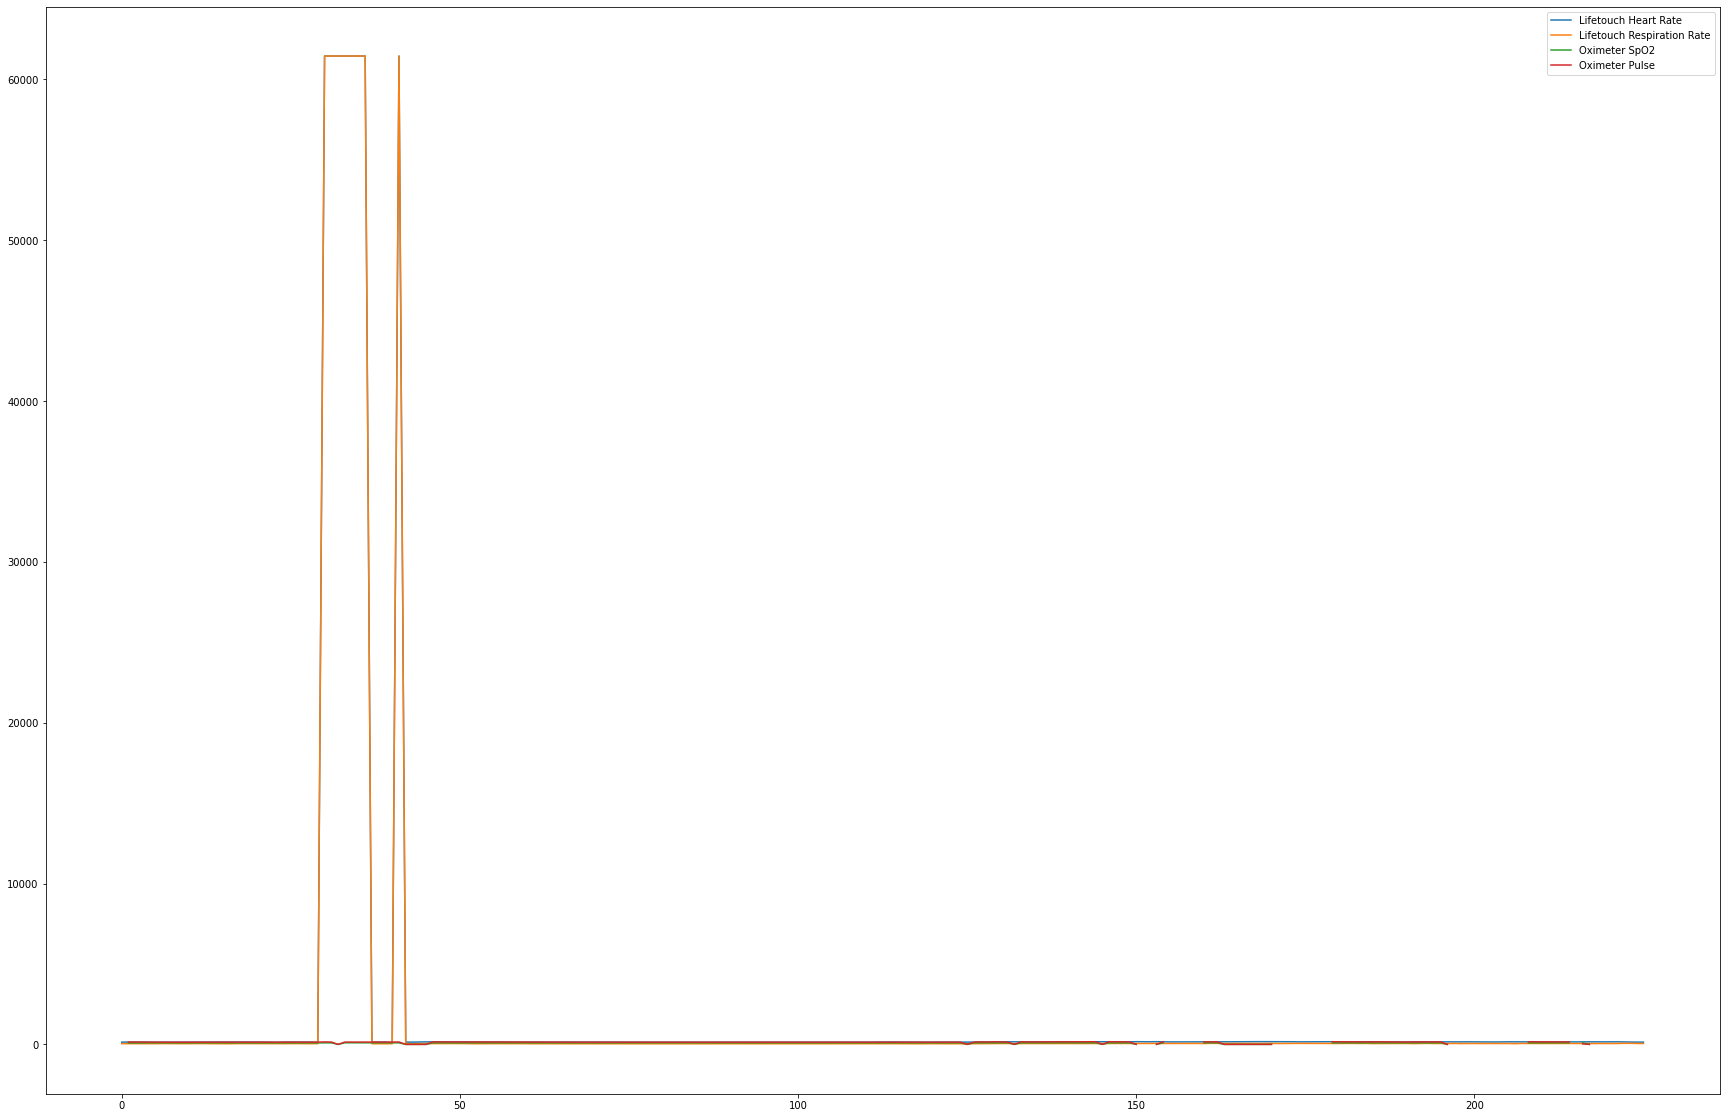

In [ ]:
#Plot our data
df = pd.read_csv("PT_Train.csv")


matplotlib.rc('figure', figsize=(30, 20))
df.plot()
#This is what my date time series looks like - messy and not useful 
#Error on the Y axis range, due to the code given to the mesurements when there is bad data. values above 1000 need to be cut off 

In [ ]:
#Data cleaning 


In [ ]:
#Data cleaning  - Important step as the ML model and data processing cannot start if the dataset contains missing values

df.isnull().values.any() #This shows if there are any missing values in the dataset. True = yes false = No

df = df.dropna() #drop any rows with missing values 

print(f'Number of entries: {len(df)}') #check if the number of entries have changed

Number of entries: 191


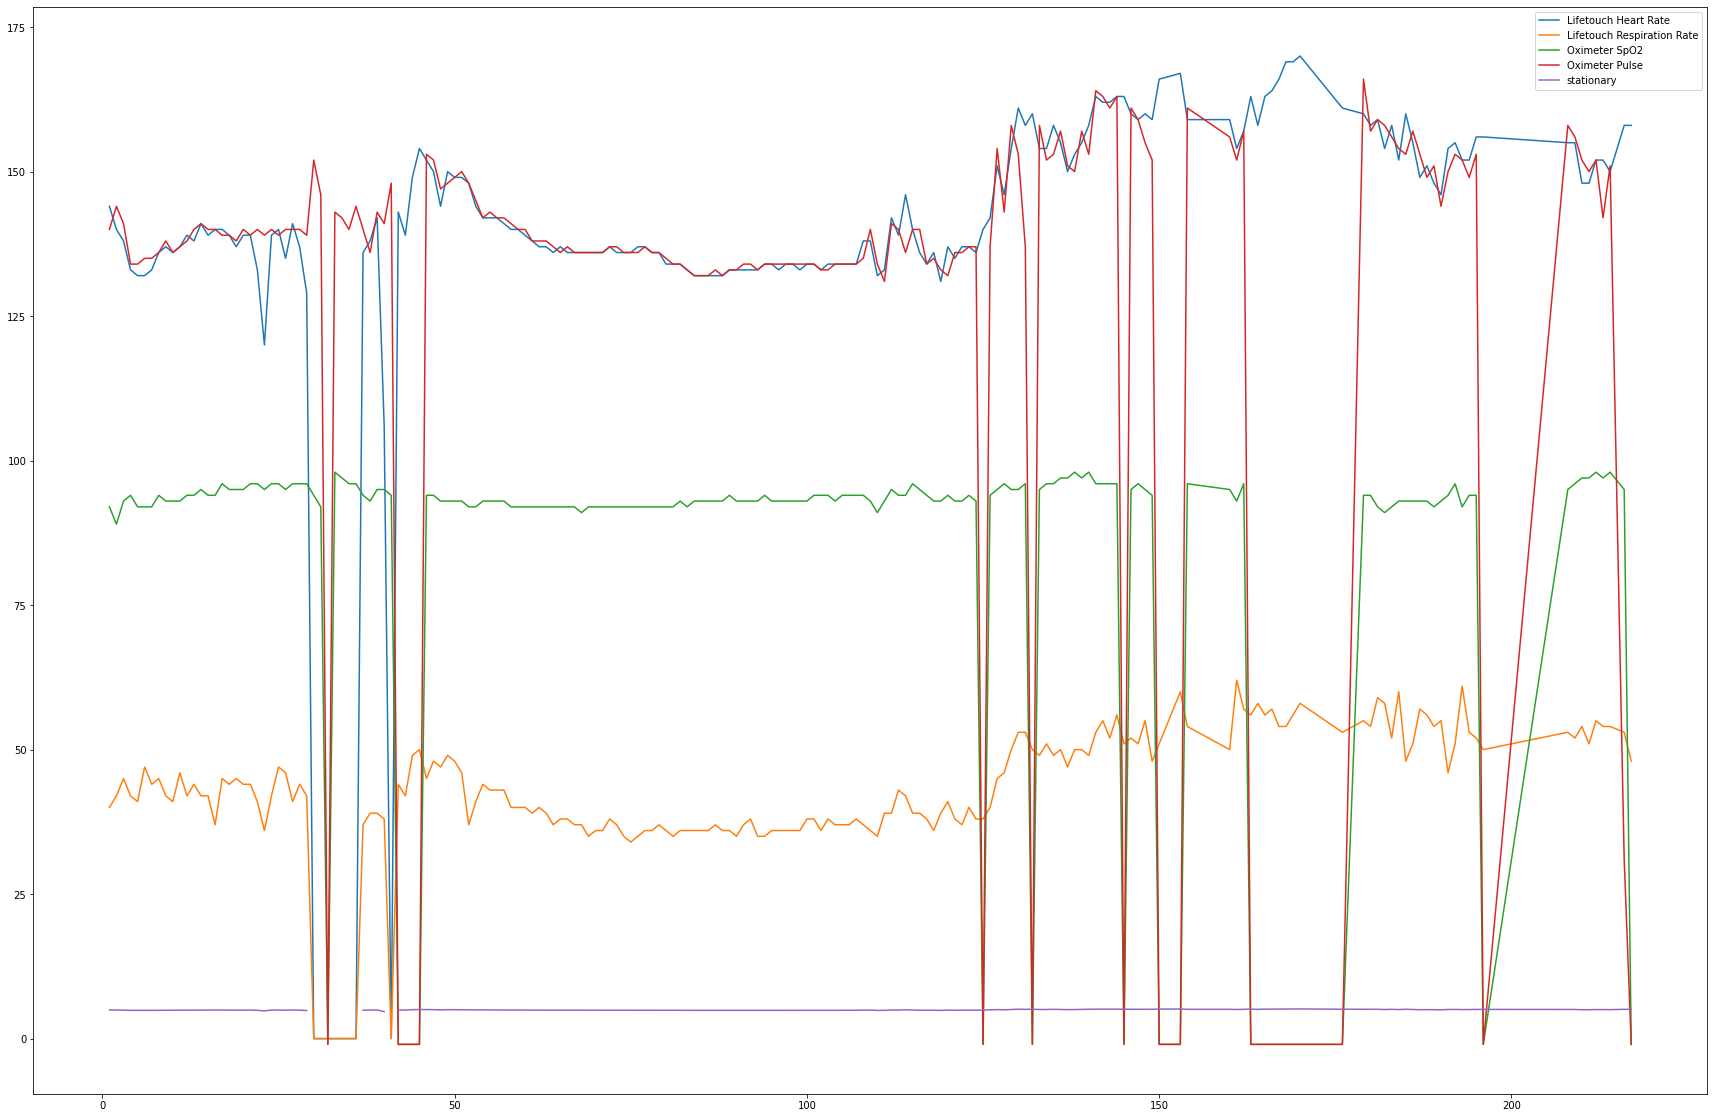

In [ ]:

#Cut off function
def cutoff(row):
    vals = row
    if vals>1000:
        vals = 0  #Any value > 1000 will be set to 0 
    return vals

matplotlib.rc('figure', figsize=(30, 20))
df['Lifetouch Heart Rate'] = df['Lifetouch Heart Rate'].apply(cutoff)
df['Lifetouch Respiration Rate'] = df['Lifetouch Respiration Rate'].apply(cutoff)
df['Oximeter SpO2'] = df['Oximeter SpO2'].apply(cutoff)
df['Oximeter Pulse'] = df['Oximeter Pulse'].apply(cutoff)
#df = df.drop(labels='Timestamp (GMT)',axis=1) #drop time stamp - not needed 
df.plot()

#blue = heart rate 
#red = pulse rate 

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1671: RuntimeWarning: invalid value encountered in subtract
  resids = x - x.mean()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. 


Result: The series is stationary



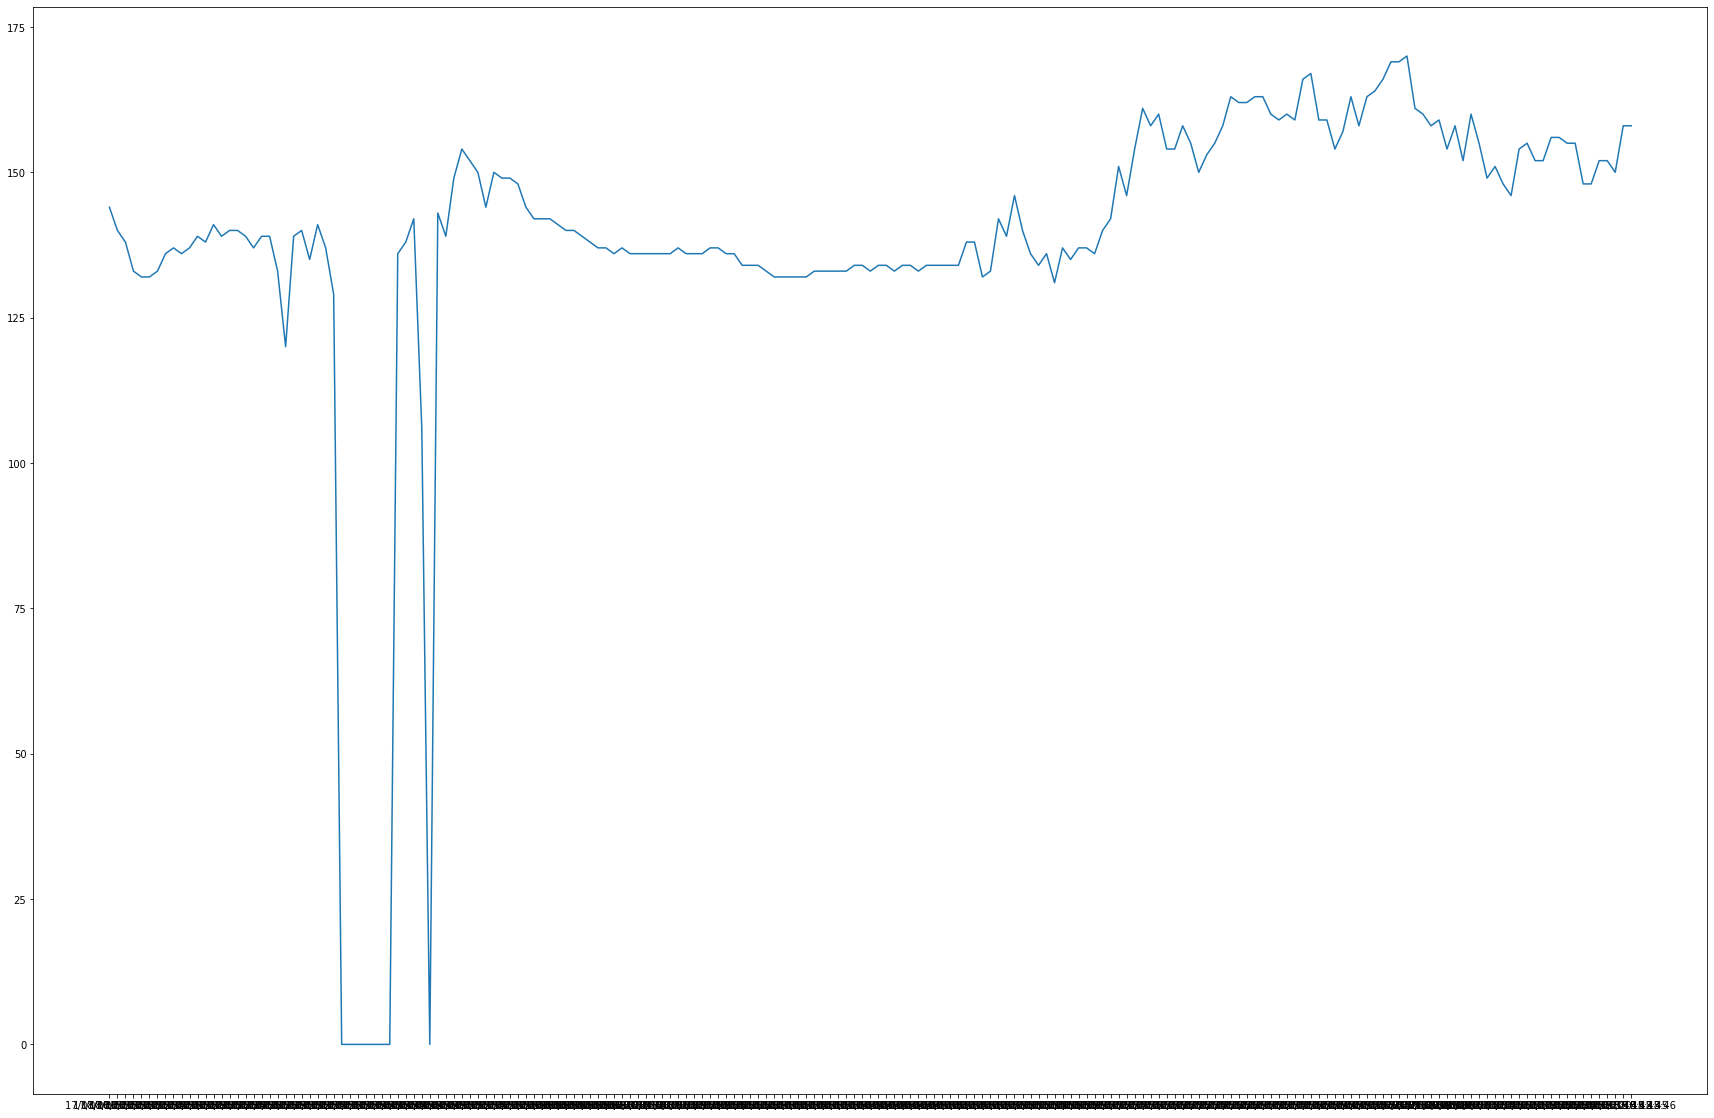

,Timestamp (GMT),Lifetouch Heart Rate,Lifetouch Respiration Rate,Oximeter SpO2,Oximeter Pulse,stationary
1,17/08/2015 15:10,144,40,92.0,140.0,4.969813
2,17/08/2015 15:11,140,42,89.0,144.0,4.941642
3,17/08/2015 15:12,138,45,93.0,141.0,4.927254
4,17/08/2015 15:13,133,42,94.0,134.0,4.890349
5,17/08/2015 15:14,132,41,92.0,134.0,4.882802


In [ ]:
#Step one - check if data is stationary using the KPSS test 

df['stationary'] = np.log(df['Lifetouch Heart Rate']) # get rid of peaks and troffs using the log function, create a new column called stationary


statistic, p_value, n_lags, critical_values = sm.tsa.stattools.kpss(df['stationary']) 
print(f'\nResult: The series is {"not " if p_value < 0.05 else ""}stationary\n')

plt.plot(df['Timestamp (GMT)'],df['Lifetouch Heart Rate'])
plt.show()
df.head()


#results show data is stationary - meaning the mean, variance and covariance do not vary with time. - 

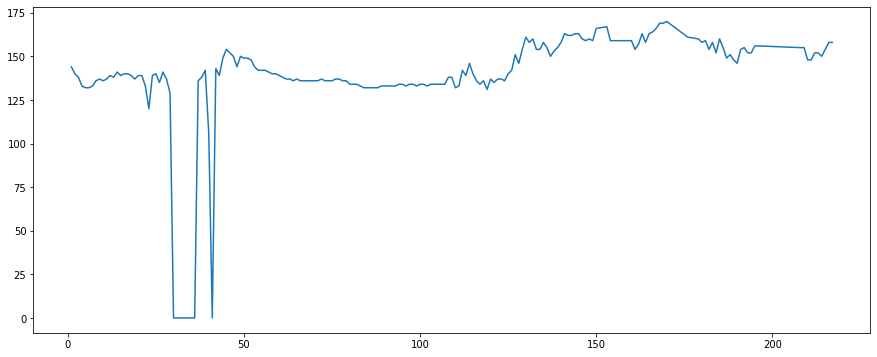

In [ ]:
#ARIMA model 
 
y = df['Lifetouch Heart Rate'] #plot only the heartrate data 


y = y.fillna(y.bfill())
y.plot(figsize=(15, 6))




In [ ]:
import itertools
p = d = q = range(0, 3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
#seasonal_pdq = [(0, 0, 0, 0)]  # change to 0000 - As the data is not affected by seasonality 
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:2876.024007590183
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:2528.7364046967577
ARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:2227.852315550589
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2173.115191254592
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1956.8995337235747
ARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:1734.1241525462838
ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:2283.3867250029884
ARIMA(0, 0, 0)x(0, 2, 1, 12)12 - AIC:1935.805815402497
ARIMA(0, 0, 0)x(0, 2, 2, 12)12 - AIC:1472.6702222487902
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2181.3763537403183
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2044.548848735229


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:1937.1600268907541
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2014.4109472542202
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1955.6497531922269
ARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:1644.9493637723895
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:2018.3802955785761
ARIMA(0, 0, 0)x(1, 2, 1, 12)12 - AIC:1921.3122747351467
ARIMA(0, 0, 0)x(1, 2, 2, 12)12 - AIC:1474.6597425871714
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:2016.0338471045102
ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:1945.9502095951534


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:1939.8647330323538
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:1753.0290237249526
ARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:1700.121454964816
ARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:1646.9437848314988
ARIMA(0, 0, 0)x(2, 2, 0, 12)12 - AIC:1642.6739554053322
ARIMA(0, 0, 0)x(2, 2, 1, 12)12 - AIC:1631.1611638381423
ARIMA(0, 0, 0)x(2, 2, 2, 12)12 - AIC:1499.149215798051
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:2576.2378312954743
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2308.7202625219265
ARIMA(0, 0, 1)x(0, 0, 2, 12)12 - AIC:2081.6560970201863
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2062.860575192414
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1835.3460631854346
ARIMA(0, 0, 1)x(0, 1, 2, 12)12 - AIC:1648.316168738442
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:2183.1193646731067
ARIMA(0, 0, 1)x(0, 2, 1, 12)12 - AIC:1843.2248037960576
ARIMA(0, 0, 1)x(0, 2, 2, 12)12 - AIC:1420.2413217574854
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:2077.497567365714
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:1922.04205230605

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 2, 2, 12)12 - AIC:1424.1516606957953
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:2436.246385203804
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:2269.770252357237
ARIMA(0, 0, 2)x(0, 0, 2, 12)12 - AIC:2038.7151189124422
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:2011.365330485991
ARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:1778.8597041743376
ARIMA(0, 0, 2)x(0, 1, 2, 12)12 - AIC:1609.4438211578085
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:2134.747343508039
ARIMA(0, 0, 2)x(0, 2, 1, 12)12 - AIC:1800.0816574985413
ARIMA(0, 0, 2)x(0, 2, 2, 12)12 - AIC:1387.0296253749561
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:2031.4250293607788
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:1900.1322744106487
ARIMA(0, 0, 2)x(1, 0, 2, 12)12 - AIC:1768.76395515085
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:1859.0582452681008
ARIMA(0, 0, 2)x(1, 1, 1, 12)12 - AIC:1774.61404733486
ARIMA(0, 0, 2)x(1, 1, 2, 12)12 - AIC:1531.2829412407575
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:1899.8684149338014
ARIMA(0, 0, 2)x(1, 2, 1, 12)12 - AIC:1753.530617935166
A

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 2, 12)12 - AIC:1770.2943665943567
ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:1666.3370893344893
ARIMA(0, 0, 2)x(2, 1, 1, 12)12 - AIC:1636.5316750265208
ARIMA(0, 0, 2)x(2, 1, 2, 12)12 - AIC:1513.000918260058
ARIMA(0, 0, 2)x(2, 2, 0, 12)12 - AIC:1568.1245567206815
ARIMA(0, 0, 2)x(2, 2, 1, 12)12 - AIC:1512.758851879726


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 2, 2, 12)12 - AIC:1428.222833945416
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:1928.4405694370428
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1827.0902847427333
ARIMA(0, 1, 0)x(0, 0, 2, 12)12 - AIC:1733.4113612274452
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:2026.6575426214881
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:1766.3380362512303
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:1598.597172627261
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:2154.6943875804145
ARIMA(0, 1, 0)x(0, 2, 1, 12)12 - AIC:1822.5530007541388
ARIMA(0, 1, 0)x(0, 2, 2, 12)12 - AIC:1394.9203581861702
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:1835.1625637917728
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:1829.0469434285872
ARIMA(0, 1, 0)x(1, 0, 2, 12)12 - AIC:1690.8855657042172
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:1847.3065641735673
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:1761.5462160105453
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:1545.03767574688
ARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:1903.1757673776297
ARIMA(0, 1, 0)x(1, 2, 1, 12)12 - AIC:1758.9072099505

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(1, 2, 2, 12)12 - AIC:1398.3108745510608
ARIMA(0, 1, 1)x(2, 0, 0, 12)12 - AIC:1741.6518511777174
ARIMA(0, 1, 1)x(2, 0, 1, 12)12 - AIC:1705.81767199825
ARIMA(0, 1, 1)x(2, 0, 2, 12)12 - AIC:1655.8107570234372
ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:1663.2443094717373
ARIMA(0, 1, 1)x(2, 1, 1, 12)12 - AIC:1639.6853880757576
ARIMA(0, 1, 1)x(2, 1, 2, 12)12 - AIC:1492.5827692203643
ARIMA(0, 1, 1)x(2, 2, 0, 12)12 - AIC:1557.5892668845606
ARIMA(0, 1, 1)x(2, 2, 1, 12)12 - AIC:1506.306086875132
ARIMA(0, 1, 1)x(2, 2, 2, 12)12 - AIC:1425.4824744768036
ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:1908.1528635962297
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:1809.3215040051023
ARIMA(0, 1, 2)x(0, 0, 2, 12)12 - AIC:1708.7549735926764
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:2000.356521175825
ARIMA(0, 1, 2)x(0, 1, 1, 12)12 - AIC:1746.0015721062855
ARIMA(0, 1, 2)x(0, 1, 2, 12)12 - AIC:1582.479592100966
ARIMA(0, 1, 2)x(0, 2, 0, 12)12 - AIC:2125.618058796351
ARIMA(0, 1, 2)x(0, 2, 1, 12)12 - AIC:1793.532698806568

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(1, 2, 2, 12)12 - AIC:1342.1356118572598
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:1741.3460814842815
ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:1705.1218868481058
ARIMA(0, 1, 2)x(2, 0, 2, 12)12 - AIC:1648.0822852637614
ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:1656.9332140598794
ARIMA(0, 1, 2)x(2, 1, 1, 12)12 - AIC:1578.1267054436712
ARIMA(0, 1, 2)x(2, 1, 2, 12)12 - AIC:1481.3638377725515
ARIMA(0, 1, 2)x(2, 2, 0, 12)12 - AIC:1550.729275905721
ARIMA(0, 1, 2)x(2, 2, 1, 12)12 - AIC:1502.812559421325
ARIMA(0, 1, 2)x(2, 2, 2, 12)12 - AIC:1411.1046381860006
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:2107.8374942824257
ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:1988.745750675834
ARIMA(0, 2, 0)x(0, 0, 2, 12)12 - AIC:1885.9537957889252
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:2204.810856611917
ARIMA(0, 2, 0)x(0, 1, 1, 12)12 - AIC:1927.0743541753272
ARIMA(0, 2, 0)x(0, 1, 2, 12)12 - AIC:1752.945386650996
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:2323.062145379791
ARIMA(0, 2, 0)x(0, 2, 1, 12)12 - AIC:1984.011143463232

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 0)x(1, 2, 2, 12)12 - AIC:1592.813003977722
ARIMA(0, 2, 0)x(2, 0, 0, 12)12 - AIC:1895.4891258985317
ARIMA(0, 2, 0)x(2, 0, 1, 12)12 - AIC:1874.6011928876806


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 0)x(2, 0, 2, 12)12 - AIC:1825.5484391959433


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 0)x(2, 1, 0, 12)12 - AIC:1815.0711857146198
ARIMA(0, 2, 0)x(2, 1, 1, 12)12 - AIC:1731.3488086875323
ARIMA(0, 2, 0)x(2, 1, 2, 12)12 - AIC:1699.9724382326608


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 0)x(2, 2, 0, 12)12 - AIC:1693.2375060152222
ARIMA(0, 2, 0)x(2, 2, 1, 12)12 - AIC:1629.172227112029
ARIMA(0, 2, 0)x(2, 2, 2, 12)12 - AIC:1560.5680923591103
ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:1919.4873409375296
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:1818.5581194636898
ARIMA(0, 2, 1)x(0, 0, 2, 12)12 - AIC:1724.4862946299759
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:2015.7497054166956
ARIMA(0, 2, 1)x(0, 1, 1, 12)12 - AIC:1758.4383284319479
ARIMA(0, 2, 1)x(0, 1, 2, 12)12 - AIC:1594.2087888473643
ARIMA(0, 2, 1)x(0, 2, 0, 12)12 - AIC:2141.252746711945
ARIMA(0, 2, 1)x(0, 2, 1, 12)12 - AIC:1813.3984528483402
ARIMA(0, 2, 1)x(0, 2, 2, 12)12 - AIC:1388.667614301153
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:1834.9066025370753
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:1792.579991344045
ARIMA(0, 2, 1)x(1, 0, 2, 12)12 - AIC:1659.2741487989806
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:1846.426977813631
ARIMA(0, 2, 1)x(1, 1, 1, 12)12 - AIC:1760.3975375694422
ARIMA(0, 2, 1)x(1, 1, 2, 12)12 - AIC:1536.88716468799

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1)x(1, 2, 2, 12)12 - AIC:1390.667385493905
ARIMA(0, 2, 1)x(2, 0, 0, 12)12 - AIC:1742.3763841813027
ARIMA(0, 2, 1)x(2, 0, 1, 12)12 - AIC:1716.6367711033058
ARIMA(0, 2, 1)x(2, 0, 2, 12)12 - AIC:1660.5140257507614
ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:1678.320226307393
ARIMA(0, 2, 1)x(2, 1, 1, 12)12 - AIC:1598.538975981609
ARIMA(0, 2, 1)x(2, 1, 2, 12)12 - AIC:1513.8534626256387
ARIMA(0, 2, 1)x(2, 2, 0, 12)12 - AIC:1566.85915769473
ARIMA(0, 2, 1)x(2, 2, 1, 12)12 - AIC:1445.9559764603805


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1)x(2, 2, 2, 12)12 - AIC:1392.740589997267
ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:1907.5674741338003
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:1809.1289709472605
ARIMA(0, 2, 2)x(0, 0, 2, 12)12 - AIC:1708.2891581761305
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:1997.4731018783084
ARIMA(0, 2, 2)x(0, 1, 1, 12)12 - AIC:1746.2378537269014
ARIMA(0, 2, 2)x(0, 1, 2, 12)12 - AIC:1588.0930944361148
ARIMA(0, 2, 2)x(0, 2, 0, 12)12 - AIC:2121.1031478653167
ARIMA(0, 2, 2)x(0, 2, 1, 12)12 - AIC:1792.477188962903
ARIMA(0, 2, 2)x(0, 2, 2, 12)12 - AIC:1342.0531143381543
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:1833.192727096846
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:1776.9924168670987
ARIMA(0, 2, 2)x(1, 0, 2, 12)12 - AIC:1631.7698972110093
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:1841.3306230493813
ARIMA(0, 2, 2)x(1, 1, 1, 12)12 - AIC:1743.630989702704
ARIMA(0, 2, 2)x(1, 1, 2, 12)12 - AIC:1503.1133771054378
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:1892.73863856558
ARIMA(0, 2, 2)x(1, 2, 1, 12)12 - AIC:1737.925568545851

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 1, 1, 12)12 - AIC:1590.746768760594
ARIMA(0, 2, 2)x(2, 1, 2, 12)12 - AIC:1487.8147662003003


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 2, 0, 12)12 - AIC:1554.5123721336438
ARIMA(0, 2, 2)x(2, 2, 1, 12)12 - AIC:1440.3176763993786


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 2, 2, 12)12 - AIC:1434.0240122905034
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:1937.2462893117417
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1836.2998494018104
ARIMA(1, 0, 0)x(0, 0, 2, 12)12 - AIC:1742.7965070060184
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:2007.4267230452633
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:1757.1924124671887
ARIMA(1, 0, 0)x(0, 1, 2, 12)12 - AIC:1621.4519253317171
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:2136.567112901326
ARIMA(1, 0, 0)x(0, 2, 1, 12)12 - AIC:1811.461910969769
ARIMA(1, 0, 0)x(0, 2, 2, 12)12 - AIC:1409.200950479436
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:1836.623943274326
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1824.5830204326653
ARIMA(1, 0, 0)x(1, 0, 2, 12)12 - AIC:1701.1380989574507
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:1825.3058745005021
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:1759.0142267462734
ARIMA(1, 0, 0)x(1, 1, 2, 12)12 - AIC:1556.3223602301478
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:1871.1837828227426
ARIMA(1, 0, 0)x(1, 2, 1, 12)12 - AIC:1754.4650435296

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(0, 0, 2, 12)12 - AIC:1726.3723610269615
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:1999.2060699318854
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:1750.2222248972607
ARIMA(1, 0, 1)x(0, 1, 2, 12)12 - AIC:1594.878107362614
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:2127.026709794339
ARIMA(1, 0, 1)x(0, 2, 1, 12)12 - AIC:1795.651036184221
ARIMA(1, 0, 1)x(0, 2, 2, 12)12 - AIC:1371.335791970675
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:1834.7235236222577
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:1802.803902520866
ARIMA(1, 0, 1)x(1, 0, 2, 12)12 - AIC:1662.9871411991128
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:1826.3122824959864
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:1752.0122494930076
ARIMA(1, 0, 1)x(1, 1, 2, 12)12 - AIC:1518.1533432982726
ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:1871.7066297224728
ARIMA(1, 0, 1)x(1, 2, 1, 12)12 - AIC:1736.2397503602142


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 2, 2, 12)12 - AIC:1400.185107386035
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:1743.3013242714005


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:1707.7104480241483


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(2, 0, 2, 12)12 - AIC:1633.053382803226
ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:1620.2044340122854
ARIMA(1, 0, 1)x(2, 1, 1, 12)12 - AIC:1550.5499982584379
ARIMA(1, 0, 1)x(2, 1, 2, 12)12 - AIC:1525.2630023781935
ARIMA(1, 0, 1)x(2, 2, 0, 12)12 - AIC:1502.98174659508
ARIMA(1, 0, 1)x(2, 2, 1, 12)12 - AIC:1467.7235820060896
ARIMA(1, 0, 1)x(2, 2, 2, 12)12 - AIC:1419.6606173839634
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:1917.4050198127993
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:1818.7943481825698


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(0, 0, 2, 12)12 - AIC:1718.6994493233226
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:1992.6721167579349
ARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:1744.506586806833
ARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:1587.317548188096
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:2119.2338148021117
ARIMA(1, 0, 2)x(0, 2, 1, 12)12 - AIC:1788.7808106776033
ARIMA(1, 0, 2)x(0, 2, 2, 12)12 - AIC:1352.0116325665736
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:1834.2014706245232
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:1794.8976406640243


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:1657.2930438006215
ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:1828.2621342926814
ARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:1741.0424269113578


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:1515.0357055938264
ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:1873.6547898531185
ARIMA(1, 0, 2)x(1, 2, 1, 12)12 - AIC:1729.3663401675649


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 2, 2, 12)12 - AIC:1356.8500675112305
ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:1743.182078188121
ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:1706.9018762914257


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:1626.7298362452216
ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:1621.0280646179026
ARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:1553.960777337696


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:1508.3263778749254
ARIMA(1, 0, 2)x(2, 2, 0, 12)12 - AIC:1502.0774762555916
ARIMA(1, 0, 2)x(2, 2, 1, 12)12 - AIC:1460.624672243321
ARIMA(1, 0, 2)x(2, 2, 2, 12)12 - AIC:1388.4676509319306
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:1924.855973073707
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1825.8467052227484
ARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:1732.3898871373024
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2018.9369852297173
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:1763.1199101573002
ARIMA(1, 1, 0)x(0, 1, 2, 12)12 - AIC:1594.4462957767494
ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:2146.369792265288
ARIMA(1, 1, 0)x(0, 2, 1, 12)12 - AIC:1815.7218383433424
ARIMA(1, 1, 0)x(0, 2, 2, 12)12 - AIC:1388.6283277724442
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:1826.122258480666
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:1816.6996174796927
ARIMA(1, 1, 0)x(1, 0, 2, 12)12 - AIC:1685.5247011810384
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:1834.8234204816795
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:1764.7804642345

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 2, 2, 12)12 - AIC:1344.4975082380774
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:1723.4156872868912
ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:1688.0951700928322
ARIMA(1, 1, 2)x(2, 0, 2, 12)12 - AIC:1643.6273544541232
ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:1601.451548974388
ARIMA(1, 1, 2)x(2, 1, 1, 12)12 - AIC:1522.1632454640385
ARIMA(1, 1, 2)x(2, 1, 2, 12)12 - AIC:1476.7092324932687
ARIMA(1, 1, 2)x(2, 2, 0, 12)12 - AIC:1488.3264942560672
ARIMA(1, 1, 2)x(2, 2, 1, 12)12 - AIC:1442.741532831734


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 2, 2, 12)12 - AIC:1405.934446883779
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:2029.8894820754476
ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:1921.0622136492643
ARIMA(1, 2, 0)x(0, 0, 2, 12)12 - AIC:1821.3727862732626
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:2123.475377344294
ARIMA(1, 2, 0)x(0, 1, 1, 12)12 - AIC:1856.7234800763724
ARIMA(1, 2, 0)x(0, 1, 2, 12)12 - AIC:1696.0700490541867
ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:2244.5491842579313
ARIMA(1, 2, 0)x(0, 2, 1, 12)12 - AIC:1915.2227364719406
ARIMA(1, 2, 0)x(0, 2, 2, 12)12 - AIC:1487.2140202514065
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:1921.9215388714629
ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:1923.057049307194
ARIMA(1, 2, 0)x(1, 0, 2, 12)12 - AIC:1761.6657831061643
ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:1929.6208096964729
ARIMA(1, 2, 0)x(1, 1, 1, 12)12 - AIC:1850.1554088831822
ARIMA(1, 2, 0)x(1, 1, 2, 12)12 - AIC:1645.8282101274194
ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:1970.2464702154912
ARIMA(1, 2, 0)x(1, 2, 1, 12)12 - AIC:1853.120118304

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(2, 2, 2, 12)12 - AIC:1491.2181206591406
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:1916.3915571106725
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC:1817.309447504264
ARIMA(1, 2, 1)x(0, 0, 2, 12)12 - AIC:1723.492987141075
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC:2008.2596341116046
ARIMA(1, 2, 1)x(0, 1, 1, 12)12 - AIC:1755.42847407142
ARIMA(1, 2, 1)x(0, 1, 2, 12)12 - AIC:1589.4141926528841
ARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:2133.188507634198
ARIMA(1, 2, 1)x(0, 2, 1, 12)12 - AIC:1805.6729207451626
ARIMA(1, 2, 1)x(0, 2, 2, 12)12 - AIC:1379.3720624874413
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:1825.3174704659698
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:1819.1463095726588
ARIMA(1, 2, 1)x(1, 0, 2, 12)12 - AIC:1657.3678124326495
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:1833.4404718691312
ARIMA(1, 2, 1)x(1, 1, 1, 12)12 - AIC:1752.8826433455847
ARIMA(1, 2, 1)x(1, 1, 2, 12)12 - AIC:1523.9042427286815
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:1879.9560868603821
ARIMA(1, 2, 1)x(1, 2, 1, 12)12 - AIC:1752.97274133534

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(1, 2, 2, 12)12 - AIC:1381.4616858140919
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:1733.3821833792797
ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:1702.1171376372854
ARIMA(1, 2, 1)x(2, 0, 2, 12)12 - AIC:1658.1989963464962
ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:1643.786329015008
ARIMA(1, 2, 1)x(2, 1, 1, 12)12 - AIC:1557.7928072696304
ARIMA(1, 2, 1)x(2, 1, 2, 12)12 - AIC:1514.1892619100388
ARIMA(1, 2, 1)x(2, 2, 0, 12)12 - AIC:1535.2215852485042
ARIMA(1, 2, 1)x(2, 2, 1, 12)12 - AIC:1427.4922531389009


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(2, 2, 2, 12)12 - AIC:1384.1152910550588
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:1900.2205663508712
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:1800.4213876634676
ARIMA(1, 2, 2)x(0, 0, 2, 12)12 - AIC:1710.0610398516637
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:1998.049343825001


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(0, 1, 1, 12)12 - AIC:1738.6457164140693
ARIMA(1, 2, 2)x(0, 1, 2, 12)12 - AIC:1568.4592637125602
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:2121.902142638094
ARIMA(1, 2, 2)x(0, 2, 1, 12)12 - AIC:1789.302075994743
ARIMA(1, 2, 2)x(0, 2, 2, 12)12 - AIC:1342.6662309792332
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:1817.6413976570175


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:1774.053694889932


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 0, 2, 12)12 - AIC:1639.8679505508808
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:1828.0568954015755
ARIMA(1, 2, 2)x(1, 1, 1, 12)12 - AIC:1735.8175347701695
ARIMA(1, 2, 2)x(1, 1, 2, 12)12 - AIC:1498.404934756993
ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:1875.8375677550443
ARIMA(1, 2, 2)x(1, 2, 1, 12)12 - AIC:1746.3012523842854


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 2, 2, 12)12 - AIC:1343.3133636703337
ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:1721.112305417382


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:1697.9894114312756


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 2, 12)12 - AIC:1645.6160195688324


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:1654.476202252591
ARIMA(1, 2, 2)x(2, 1, 1, 12)12 - AIC:1549.5644727465688


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 1, 2, 12)12 - AIC:1579.200083980773
ARIMA(1, 2, 2)x(2, 2, 0, 12)12 - AIC:1517.5431486903121


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 2, 1, 12)12 - AIC:1422.013932112936


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 2, 2, 12)12 - AIC:1335.5282139095189
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:1926.189158476294
ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:1835.119469395135


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(0, 0, 2, 12)12 - AIC:1741.991245473805
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:1999.1287879494587
ARIMA(2, 0, 0)x(0, 1, 1, 12)12 - AIC:1758.3821334915124
ARIMA(2, 0, 0)x(0, 1, 2, 12)12 - AIC:1622.635296202719
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:2126.9279825541003
ARIMA(2, 0, 0)x(0, 2, 1, 12)12 - AIC:1812.3732972640962
ARIMA(2, 0, 0)x(0, 2, 2, 12)12 - AIC:1411.1666378659754
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:1827.695797522451
ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:1804.699351460782


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(1, 0, 2, 12)12 - AIC:1695.489478040597
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:1818.2185616315087
ARIMA(2, 0, 0)x(1, 1, 1, 12)12 - AIC:1747.2095912555799
ARIMA(2, 0, 0)x(1, 1, 2, 12)12 - AIC:1557.1186326603495
ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:1854.2672772621581
ARIMA(2, 0, 0)x(1, 2, 1, 12)12 - AIC:1736.2104051191632
ARIMA(2, 0, 0)x(1, 2, 2, 12)12 - AIC:1413.166191048877
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:1736.107050240686
ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:1687.0816283235476
ARIMA(2, 0, 0)x(2, 0, 2, 12)12 - AIC:1637.356952859312
ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:1591.040047511734
ARIMA(2, 0, 0)x(2, 1, 1, 12)12 - AIC:1511.8387824513004
ARIMA(2, 0, 0)x(2, 1, 2, 12)12 - AIC:1487.0062920913647
ARIMA(2, 0, 0)x(2, 2, 0, 12)12 - AIC:1480.8505039172978
ARIMA(2, 0, 0)x(2, 2, 1, 12)12 - AIC:1412.900955694155


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 2, 2, 12)12 - AIC:1419.5766997925289
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:1913.4045246811622
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:1814.4636357003274


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(0, 0, 2, 12)12 - AIC:1728.2801295558834
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:2001.1105011349127
ARIMA(2, 0, 1)x(0, 1, 1, 12)12 - AIC:1752.0211812835173
ARIMA(2, 0, 1)x(0, 1, 2, 12)12 - AIC:1581.679559473961
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:2128.9096605678196
ARIMA(2, 0, 1)x(0, 2, 1, 12)12 - AIC:1797.4438952239607
ARIMA(2, 0, 1)x(0, 2, 2, 12)12 - AIC:1363.611159710742
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:1814.65145021232


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:1803.2859327455267


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 0, 2, 12)12 - AIC:1672.366332705363
ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:1820.197486677038
ARIMA(2, 0, 1)x(1, 1, 1, 12)12 - AIC:1749.1859085544866
ARIMA(2, 0, 1)x(1, 1, 2, 12)12 - AIC:1516.386941665126
ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:1856.1097042113126
ARIMA(2, 0, 1)x(1, 2, 1, 12)12 - AIC:1735.2614357107414


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 2, 2, 12)12 - AIC:1375.9811144803955
ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:1720.8498450370348


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:1690.2400023533817


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 2, 12)12 - AIC:1638.0827406144608
ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:1590.0073042860101


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 1, 1, 12)12 - AIC:1510.834466534423


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 1, 2, 12)12 - AIC:1526.9813770017222
ARIMA(2, 0, 1)x(2, 2, 0, 12)12 - AIC:1472.9570916006323


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 2, 1, 12)12 - AIC:1401.5036137117906


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 2, 2, 12)12 - AIC:1417.6080382729729
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:1906.4327399766048


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:1810.8679935315429
ARIMA(2, 0, 2)x(0, 0, 2, 12)12 - AIC:1708.9160676432002
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:1980.6221596789164
ARIMA(2, 0, 2)x(0, 1, 1, 12)12 - AIC:1738.2764594536616
ARIMA(2, 0, 2)x(0, 1, 2, 12)12 - AIC:1588.5335124688418
ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:2105.900763552538
ARIMA(2, 0, 2)x(0, 2, 1, 12)12 - AIC:1790.653293524795
ARIMA(2, 0, 2)x(0, 2, 2, 12)12 - AIC:1345.6542406379453


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:1815.7540463512935


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:1794.5674564836265


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 0, 2, 12)12 - AIC:1717.0996064713552
ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:1811.54869533912
ARIMA(2, 0, 2)x(1, 1, 1, 12)12 - AIC:1737.431914538849
ARIMA(2, 0, 2)x(1, 1, 2, 12)12 - AIC:1508.1880831285143
ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:1858.2239726523544


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 2, 1, 12)12 - AIC:1731.4045656515923


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 2, 2, 12)12 - AIC:1628.3707541232693


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:1725.2043301944666


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:1738.8932564398442


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 2, 12)12 - AIC:1730.4665732182318
ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:1591.769068931187
ARIMA(2, 0, 2)x(2, 1, 1, 12)12 - AIC:1507.0797680417834


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 2, 12)12 - AIC:1507.198284339553


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 2, 0, 12)12 - AIC:1484.2703641172238


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 2, 1, 12)12 - AIC:1649.8878221990951


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 2, 2, 12)12 - AIC:1498.759341879288
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:1918.151794509132
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:1827.0225943647652
ARIMA(2, 1, 0)x(0, 0, 2, 12)12 - AIC:1733.6522124467388
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:2010.7552545896342
ARIMA(2, 1, 0)x(0, 1, 1, 12)12 - AIC:1764.268895428368
ARIMA(2, 1, 0)x(0, 1, 2, 12)12 - AIC:1594.4196353080088
ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:2136.9285511783637
ARIMA(2, 1, 0)x(0, 2, 1, 12)12 - AIC:1815.4312252125924
ARIMA(2, 1, 0)x(0, 2, 2, 12)12 - AIC:1389.5811052764175
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:1819.6622761742656
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:1795.4611357016643
ARIMA(2, 1, 0)x(1, 0, 2, 12)12 - AIC:1685.5819206966025
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:1827.4199607666474
ARIMA(2, 1, 0)x(1, 1, 1, 12)12 - AIC:1757.9473682239773
ARIMA(2, 1, 0)x(1, 1, 2, 12)12 - AIC:1533.8881797036615
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:1863.1515648887444
ARIMA(2, 1, 0)x(1, 2, 1, 12)12 - AIC:1746.163429888

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:1511.6331274023378
ARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:1486.420412140098
ARIMA(2, 1, 1)x(2, 2, 0, 12)12 - AIC:1476.314660973056
ARIMA(2, 1, 1)x(2, 2, 1, 12)12 - AIC:1401.8161902852235


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 2, 2, 12)12 - AIC:1379.0168635112316
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:1890.9735397323443
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:1792.7137992744092
ARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:1696.0732463423146
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:1989.4836915776182
ARIMA(2, 1, 2)x(0, 1, 1, 12)12 - AIC:1733.8750535339136
ARIMA(2, 1, 2)x(0, 1, 2, 12)12 - AIC:1580.068199733688
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:2113.5439777646757
ARIMA(2, 1, 2)x(0, 2, 1, 12)12 - AIC:1788.959273483217
ARIMA(2, 1, 2)x(0, 2, 2, 12)12 - AIC:1304.1583438845548
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:1801.259046743539
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:1794.5404007801908


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 0, 2, 12)12 - AIC:1642.6720940454538
ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:1809.8797319869584
ARIMA(2, 1, 2)x(1, 1, 1, 12)12 - AIC:1735.56198972319


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 2, 12)12 - AIC:1492.6878089840868
ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:1846.0870225169456
ARIMA(2, 1, 2)x(1, 2, 1, 12)12 - AIC:1727.7670243789662


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 2, 2, 12)12 - AIC:1307.9839261510924
ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:1700.9491837958935


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:1663.3594537931758
ARIMA(2, 1, 2)x(2, 0, 2, 12)12 - AIC:1639.5788896825115


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:1569.5109808166735


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 1, 12)12 - AIC:1487.3917753887893


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 2, 12)12 - AIC:1516.364921466919
ARIMA(2, 1, 2)x(2, 2, 0, 12)12 - AIC:1476.4599295682651


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 2, 1, 12)12 - AIC:1398.6548357595698


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 2, 2, 12)12 - AIC:1401.1139982727773
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:1996.002880639387
ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:1899.511260145604
ARIMA(2, 2, 0)x(0, 0, 2, 12)12 - AIC:1801.6654466671087
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:2085.357382044284
ARIMA(2, 2, 0)x(0, 1, 1, 12)12 - AIC:1834.0923443756515
ARIMA(2, 2, 0)x(0, 1, 2, 12)12 - AIC:1675.5850884455667
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:2205.983448206127
ARIMA(2, 2, 0)x(0, 2, 1, 12)12 - AIC:1888.6349546388305
ARIMA(2, 2, 0)x(0, 2, 2, 12)12 - AIC:1475.3450537461758
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:1891.96962997838
ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:1871.2125157677228
ARIMA(2, 2, 0)x(1, 0, 2, 12)12 - AIC:1738.5049139728808
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:1896.5529204414383
ARIMA(2, 2, 0)x(1, 1, 1, 12)12 - AIC:1820.5568436590506
ARIMA(2, 2, 0)x(1, 1, 2, 12)12 - AIC:1623.3877985123636
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:1933.7412301826112
ARIMA(2, 2, 0)x(1, 2, 1, 12)12 - AIC:1817.510591225399

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(2, 1, 2, 12)12 - AIC:1572.558971602326
ARIMA(2, 2, 0)x(2, 2, 0, 12)12 - AIC:1573.3797267443301
ARIMA(2, 2, 0)x(2, 2, 1, 12)12 - AIC:1505.245966445576


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(2, 2, 2, 12)12 - AIC:1463.7047708799014
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:1917.7184026336035
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:1818.485830238174
ARIMA(2, 2, 1)x(0, 0, 2, 12)12 - AIC:1724.789295749346
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:2008.7374811738987
ARIMA(2, 2, 1)x(0, 1, 1, 12)12 - AIC:1756.5949380163336
ARIMA(2, 2, 1)x(0, 1, 2, 12)12 - AIC:1589.1874525483083
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:2133.640019411075
ARIMA(2, 2, 1)x(0, 2, 1, 12)12 - AIC:1805.4210762001896
ARIMA(2, 2, 1)x(0, 2, 2, 12)12 - AIC:1376.9241376840423
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:1818.740039410637
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:1787.6511857938885
ARIMA(2, 2, 1)x(1, 0, 2, 12)12 - AIC:1657.9009036025654
ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:1825.582034942166
ARIMA(2, 2, 1)x(1, 1, 1, 12)12 - AIC:1754.1189043904515
ARIMA(2, 2, 1)x(1, 1, 2, 12)12 - AIC:1520.5609836442989
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:1867.2177639815668
ARIMA(2, 2, 1)x(1, 2, 1, 12)12 - AIC:1754.41707285777

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(1, 2, 2, 12)12 - AIC:1378.8811685533324
ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:1726.673478398849
ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:1684.3695225339866
ARIMA(2, 2, 1)x(2, 0, 2, 12)12 - AIC:1659.5458491453655
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:1626.0371882259933
ARIMA(2, 2, 1)x(2, 1, 1, 12)12 - AIC:1542.7574962072417
ARIMA(2, 2, 1)x(2, 1, 2, 12)12 - AIC:1509.7123872690104
ARIMA(2, 2, 1)x(2, 2, 0, 12)12 - AIC:1519.2019515142276
ARIMA(2, 2, 1)x(2, 2, 1, 12)12 - AIC:1414.2927487459033


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 2, 2, 12)12 - AIC:1473.132414444195
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:1898.4011037593345
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:1801.256091041159
ARIMA(2, 2, 2)x(0, 0, 2, 12)12 - AIC:1702.9210102540733
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:1984.4843942512362
ARIMA(2, 2, 2)x(0, 1, 1, 12)12 - AIC:1741.3617556491092
ARIMA(2, 2, 2)x(0, 1, 2, 12)12 - AIC:1580.6207194948051


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:2112.922758947987
ARIMA(2, 2, 2)x(0, 2, 1, 12)12 - AIC:1780.4567405139392
ARIMA(2, 2, 2)x(0, 2, 2, 12)12 - AIC:1317.01983836078
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:1809.392297546749
ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:1768.4716018105928


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 0, 2, 12)12 - AIC:1633.1828965954269
ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:1814.5754110634407
ARIMA(2, 2, 2)x(1, 1, 1, 12)12 - AIC:1740.2757075186819
ARIMA(2, 2, 2)x(1, 1, 2, 12)12 - AIC:1491.2694043031252


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:1856.3968137407032
ARIMA(2, 2, 2)x(1, 2, 1, 12)12 - AIC:1732.1421522834721


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 2, 2, 12)12 - AIC:1307.8610461055418
ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:1713.5237359465393
ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:1682.583258534144
ARIMA(2, 2, 2)x(2, 0, 2, 12)12 - AIC:1645.1994934527743
ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:1616.4029081639187
ARIMA(2, 2, 2)x(2, 1, 1, 12)12 - AIC:1532.9163523399397


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 1, 2, 12)12 - AIC:1476.2692167582927
ARIMA(2, 2, 2)x(2, 2, 0, 12)12 - AIC:1507.7547275483944


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 1, 12)12 - AIC:1368.5790410750733


/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 2, 2, 12)12 - AIC:1288.355599054738
